## To analyse the brain segmentation results

In [76]:
RUN_ID = 2
ROOT_DIR = "/scratch1/sachinsa/brats_seg"
DATA_ROOT_DIR = "/scratch1/sachinsa/data"

In [77]:
import os
import matplotlib.pyplot as plt

import pdb
import numpy as np
import pickle
from utils.logger import Logger

logger = Logger(log_level='DEBUG')

[INFO] Logging level is: DEBUG


In [78]:
load_dir = os.path.join(ROOT_DIR, f"run_{RUN_ID}")
fig_save_dir = os.path.join("..", "figs", f"run_{RUN_ID}")
os.makedirs(fig_save_dir, exist_ok=True)

In [79]:
with open(os.path.join(load_dir, 'training_info.pkl'), 'rb') as f:
    training_info = pickle.load(f)
    epoch_loss_values = training_info['epoch_loss_values']
    metric_values = training_info['metric_values']
    metric_values_tc = training_info['metric_values_tc']
    metric_values_wt = training_info['metric_values_wt']
    metric_values_et = training_info['metric_values_et']

In [80]:
max_epochs = len(epoch_loss_values)
val_interval = len(epoch_loss_values)//len(metric_values)
logger.info(f"Total epochs: {max_epochs}")

[INFO] Total epochs: 25


### Plot the loss and metric

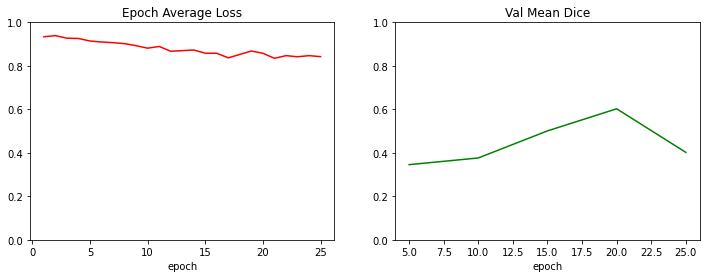

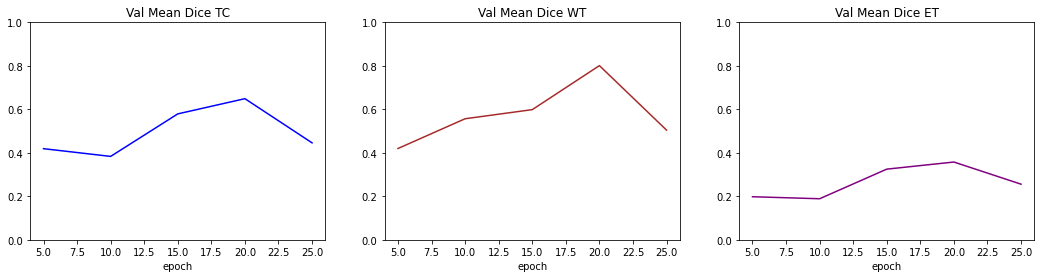

In [81]:
plt.figure("train", (12, 4))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.ylim((0, 1))
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.ylim((0, 1))
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 4))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.ylim((0, 1))
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.ylim((0, 1))
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.ylim((0, 1))
plt.plot(x, y, color="purple")
plt.show()

## Inference on the model

In [82]:
import torch
from monai.transforms import (
    Compose,
)
from torch.utils.data import Dataset

from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
)
from monai.utils import set_determinism
from tqdm import tqdm
from utils.transforms import tumor_seg_transform as data_transform

import torch

In [83]:
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)

In [84]:
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    with torch.amp.autocast('cuda'):
        return _compute(input)

In [85]:
val_ds = DecathlonDataset(
    root_dir=DATA_ROOT_DIR,
    task="Task01_BrainTumour",
    transform=data_transform['val'],
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=8,#4,
)

val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=8)

In [86]:
checkpoint = torch.load(os.path.join(load_dir, 'best_checkpoint.pth'), weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval();

In [87]:
val_index = 6
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    input_image = val_ds[val_index]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    this_output = inference(input_image)
    this_output = post_trans(this_output[0])

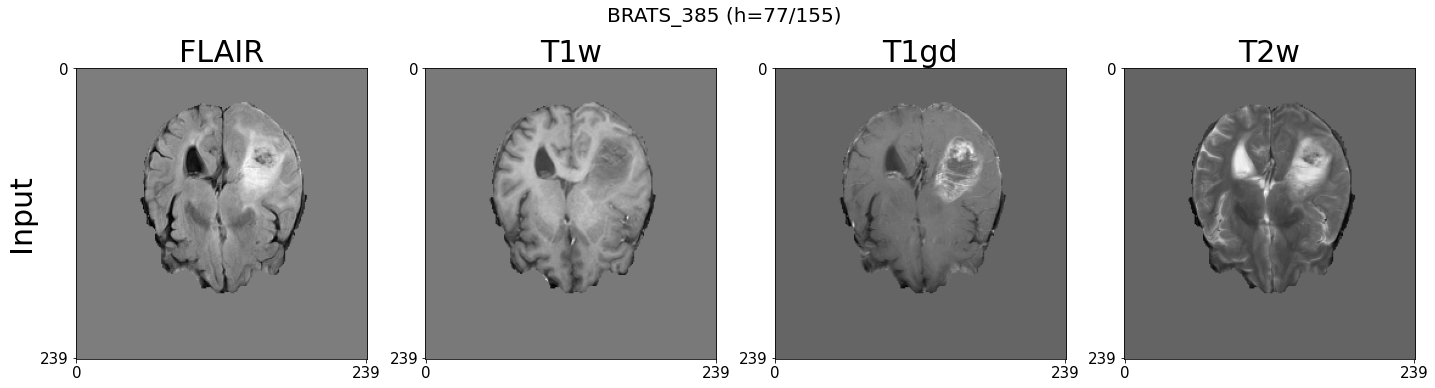

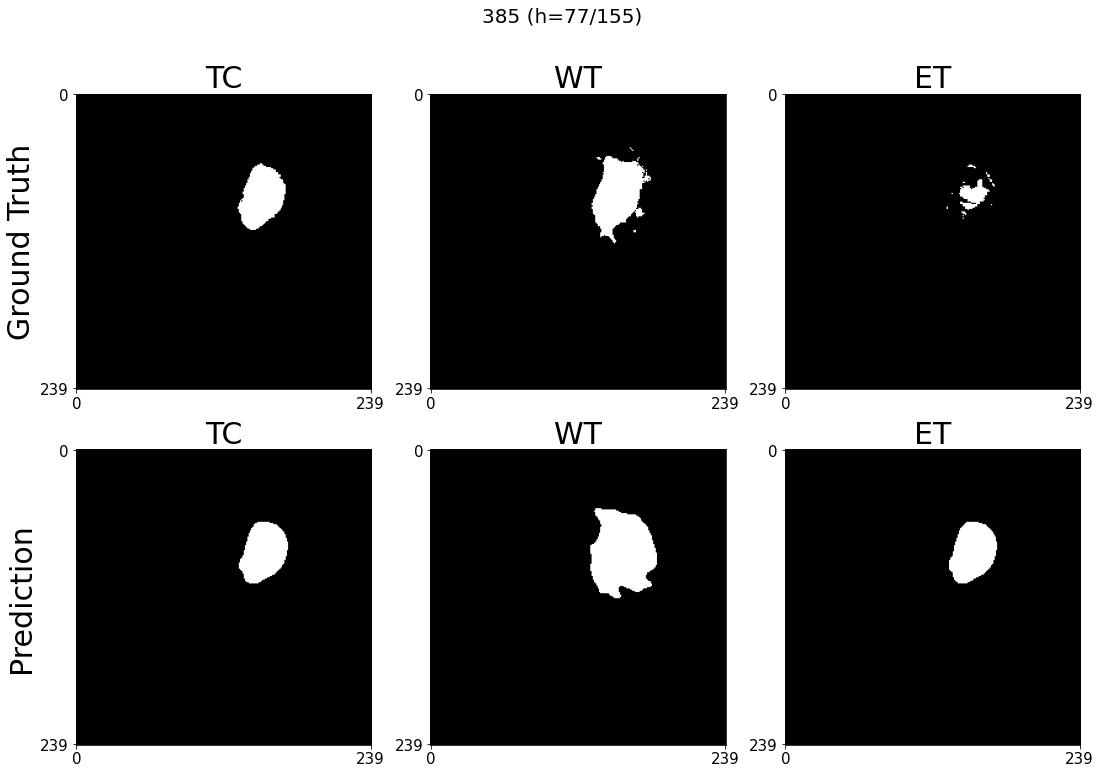

In [88]:
_, _, im_length, im_width, im_height = input_image.shape
h_index = im_height//2
label_list = ["TC", "WT", "ET"]
channels = ["FLAIR", "T1w", "T1gd", "T2w"]

def plot_brain(index, label):
    if label == "ground_truth":
        start_index = 0
        brain_slice = val_ds[val_index]["label"]
        title = "Ground Truth"
    elif label == "prediction":
        start_index = len(label_list)
        brain_slice = this_output
        title = "Prediction"

    brain_slice = brain_slice[index, :, :, 70].detach().cpu().T
    plt.subplot(2, 3, start_index + index + 1)
    plt.title(label_list[index], fontsize=30)
    if index == 0:
        plt.ylabel(title, fontsize=30)
    plt.xticks([0, im_width - 1], [0, im_width - 1], fontsize=15)
    plt.yticks([0, im_length - 1], [0, im_length - 1], fontsize=15)
    plt.imshow(brain_slice, cmap="gray")


plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(channels[i], fontsize=30)
    if i == 0:
        plt.ylabel("Input", fontsize=30)
    plt.xticks([0, im_width - 1], [0, im_width - 1], fontsize=15)
    plt.yticks([0, im_length - 1], [0, im_length - 1], fontsize=15)
    plt.imshow(val_ds[val_index]["image"][i, :, :, 70].detach().cpu().T, cmap="gray")
plt.suptitle(f"BRATS_{val_ds.get_indices()[val_index]} (h={h_index}/{im_height})", fontsize=20)
plt.show()
    
plt.figure("label", (18, 12))
for i in range(len(label_list)):
    plot_brain(i, "ground_truth")
for i in range(len(label_list)):
    plot_brain(i, "prediction")
plt.suptitle(f"{val_ds.get_indices()[val_index]} (h={h_index}/{im_height})", fontsize=20)
plt.show()

In [89]:
# with torch.no_grad():
#     # i = 0
#     for val_data in val_loader:
#         # i += 1
#         # if i > 4: break
#         val_inputs, val_labels = (
#             val_data["image"].to(device),
#             val_data["label"].to(device),
#         )
#         val_outputs = inference(val_inputs)
#         val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
#         dice_metric(y_pred=val_outputs, y=val_labels)
#         dice_metric_batch(y_pred=val_outputs, y=val_labels)

#     metric = dice_metric.aggregate().item()
#     metric_batch_org = dice_metric_batch.aggregate()

#     dice_metric.reset()
#     dice_metric_batch.reset()

# metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

# print(f"metric: {metric:.3f}")
# print(f"metric_tc: {metric_tc:.3f}")
# print(f"metric_wt: {metric_wt:.3f}")
# print(f"metric_et: {metric_et:.3f}")